# Growth dynamics

In this tutorial, we'll use Pycea to explore tumor growth dynamics in spatially-resolved lineage tracing data from [Koblan et al. 2025](https://www.science.org/doi/10.1126/science.adx3800). 

This study profiled mouse 4T1 breast carcinoma tumors with the PEtracer system which can be read out using either scRNA-seq or MERFISH-style imaging. Here we will focus on three tumors sections from mouse 3 tumor 1, which were profiled with imaging. The full dataset is available on [Figshare](https://figshare.com/s/8e9d573deca3d44235fe).

In [ ]:
import pycea as py
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["figure.dpi"] = 600
edit_cmap = mcolors.ListedColormap(["white","lightgray","#CD2626", "#E69F00", "#FFE600",
                    "#009E73", "#83A4FF", "#1874CD", "#8E0496", "#DB65D2"])

The 4T1 data can be easily loaded using {func}`pycea.datasets.koblan25()`.

In [ ]:
tdata = py.datasets.koblan25()
tdata

TreeData object with n_obs × n_vars = 104219 × 175
    obs: 'sample', 'cell', 'cellBC', 'fov', 'centroid_x', 'centroid_y', 'centroid_z', 'n_layers', 'volume', 'n_genes_by_counts', 'total_counts', 'cell_subtype', 'true_proportion', 'diffusion_proportion', 'background_proportion', 'total_density', 'tumor', 'tumor_boundary_dist', 'within_tumor', 'lung_boundary_dist', 'type', 'clone', 'detection_rate', 'tree', 'fitness', 'clade', 'character_dist_of_relatives', 'local_character_diversity', 'hotspot_module', 'phase', 'edit_frac', 'leiden_cluster'
    uns: 'clone_characters', 'clone_colors', 'hotspot_module_colors', 'leiden_cluster_colors', 'within_tumor_colors', 'clade_colors', 'n_extant'
    obsm: 'X_resolVI', 'X_umap', 'characters', 'module_scores', 'resolvi_celltypes', 'spatial', 'spatial_grid', 'spatial_overlay', 'subtype_density'
    obst: 'tree'

## Clades

First let's identify clades in the tumor that share a common ancestor at day five using {func}`pycea.tl.clades`.

In [3]:
py.tl.clades(tdata, depth = 5, depth_key="time", update = False)

We can then use {func}`pycea.get.pallette` to create a rainbow color scheme to visualize the clades.

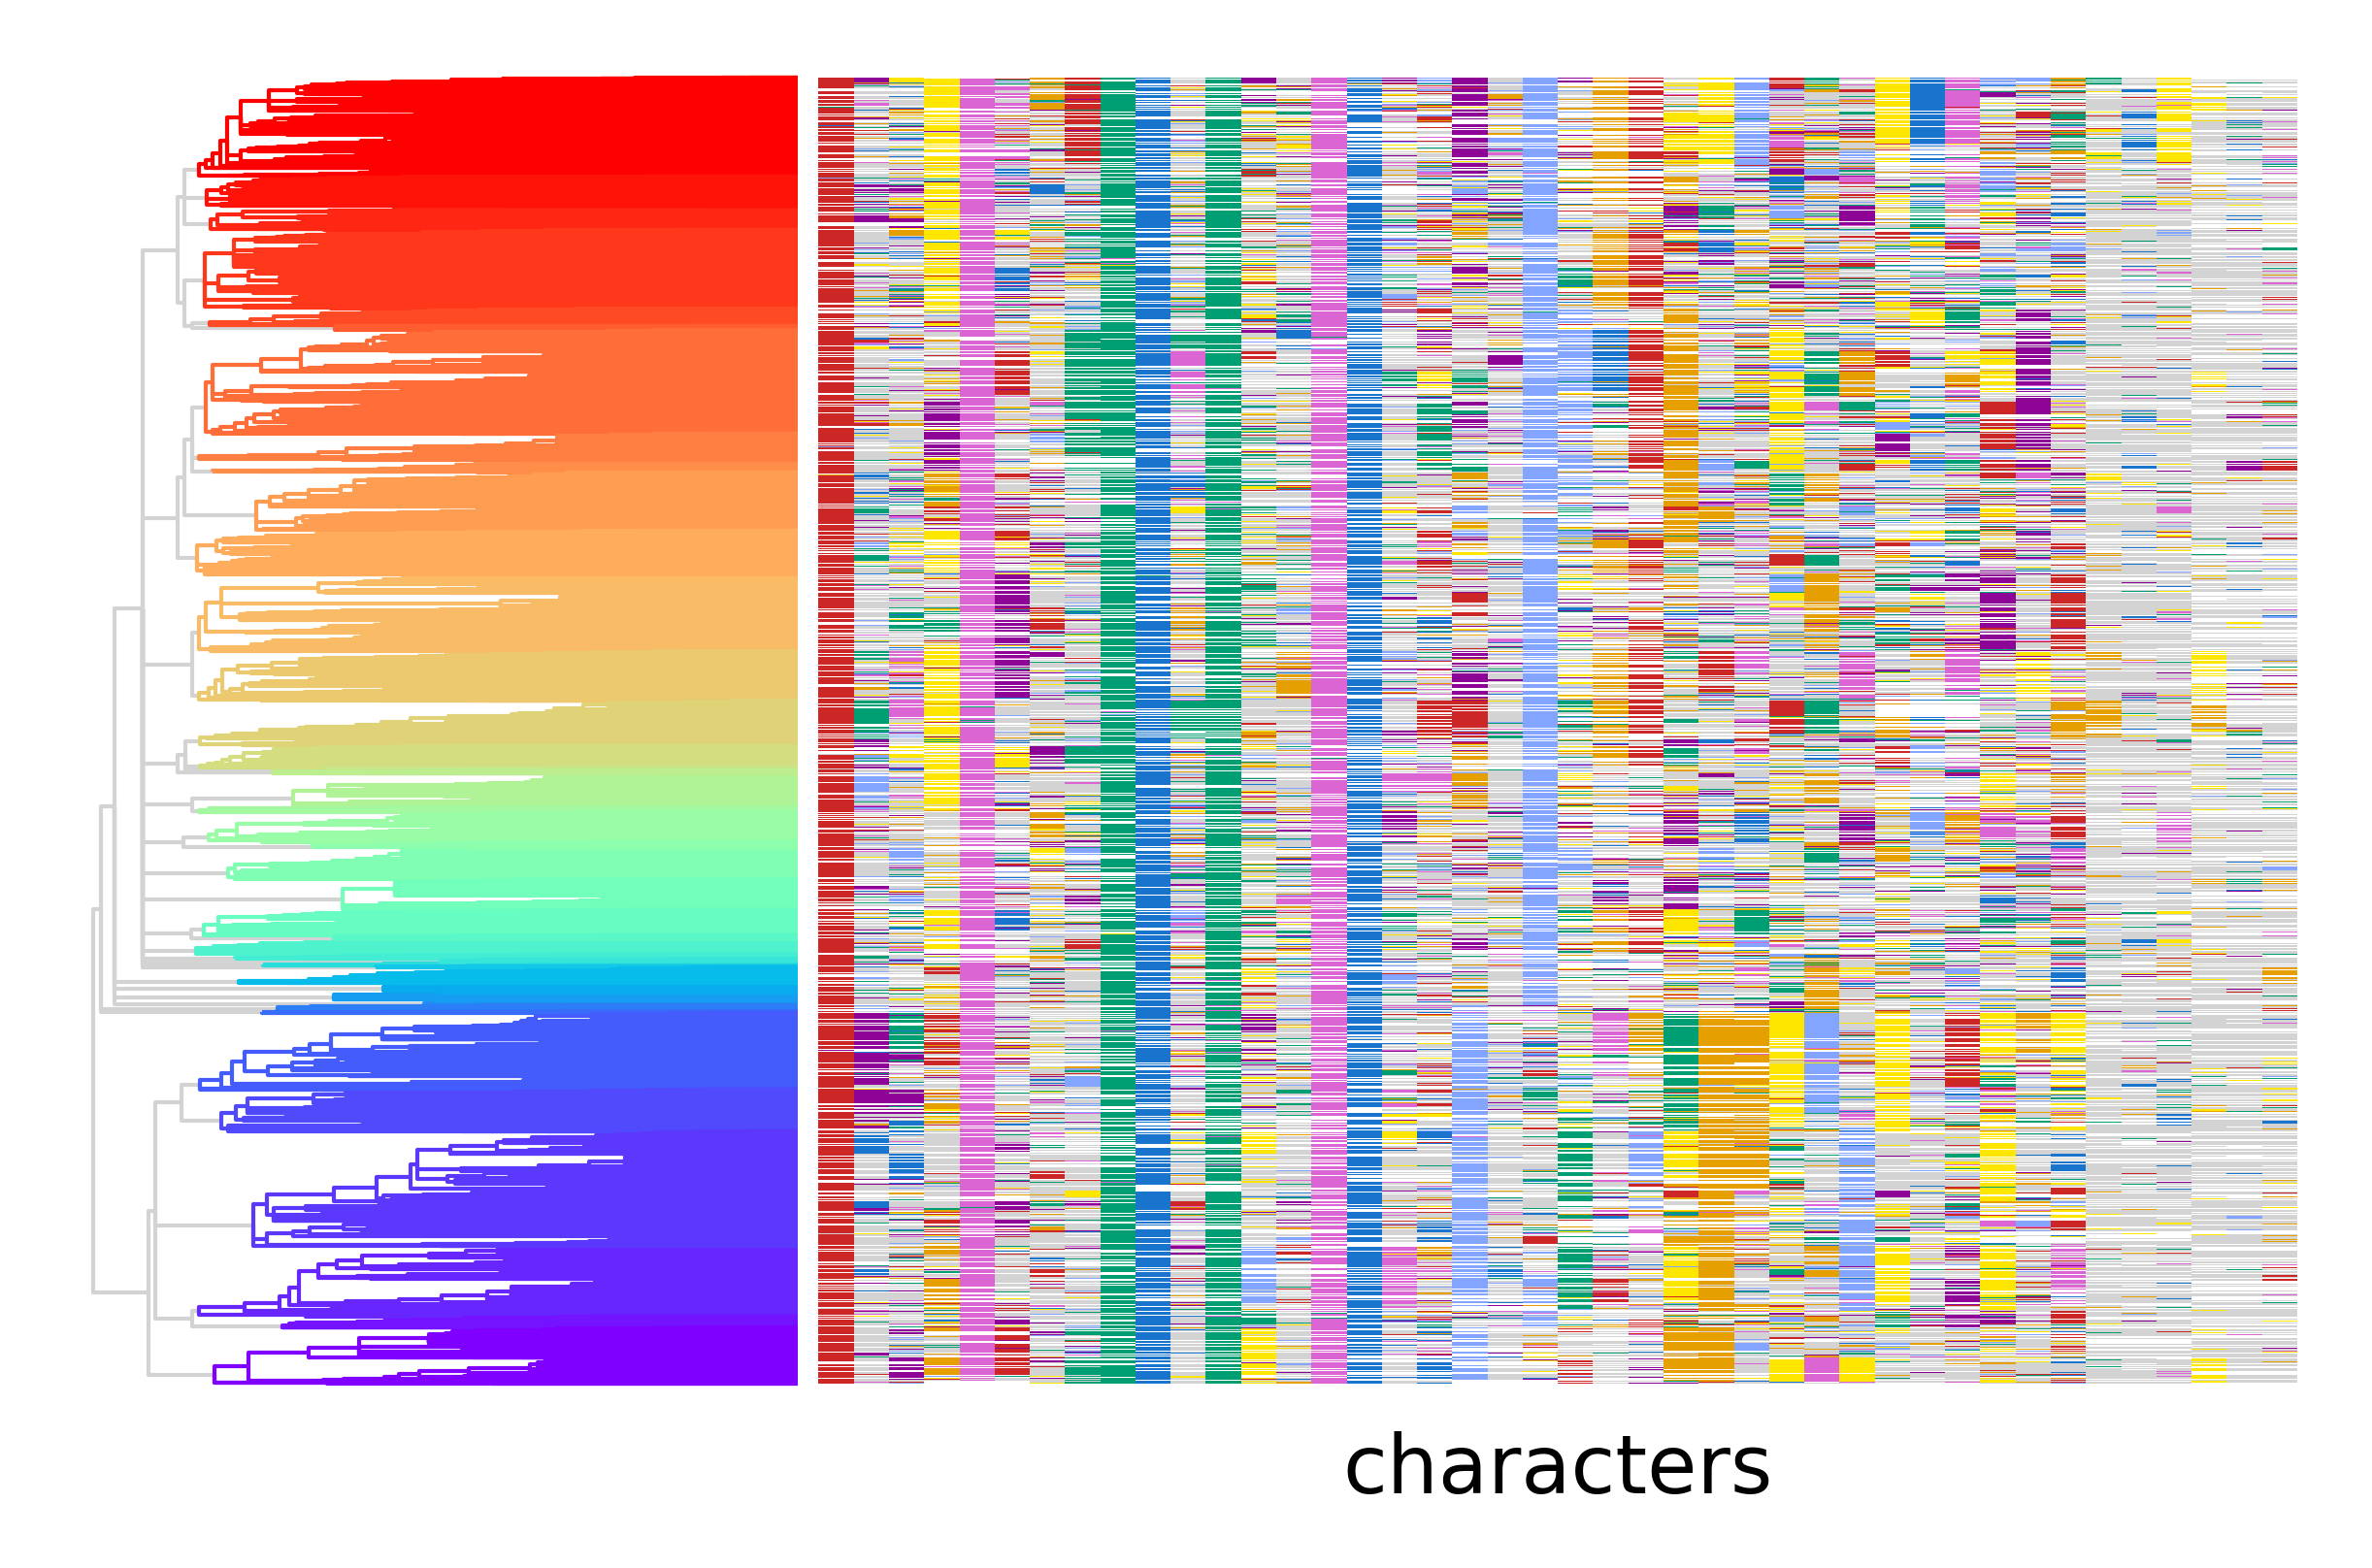

In [25]:
clade_palette = py.get.palette(tdata,key = "clade",cmap = "rainbow")
py.pl.tree(tdata,depth_key="time", branch_color="clade", palette=clade_palette)
py.pl.annotation(tdata, keys = "characters",cmap=edit_cmap, legend = False);

Using this color scheme we can also visualize the spatial distribution of clades in each tumor section.

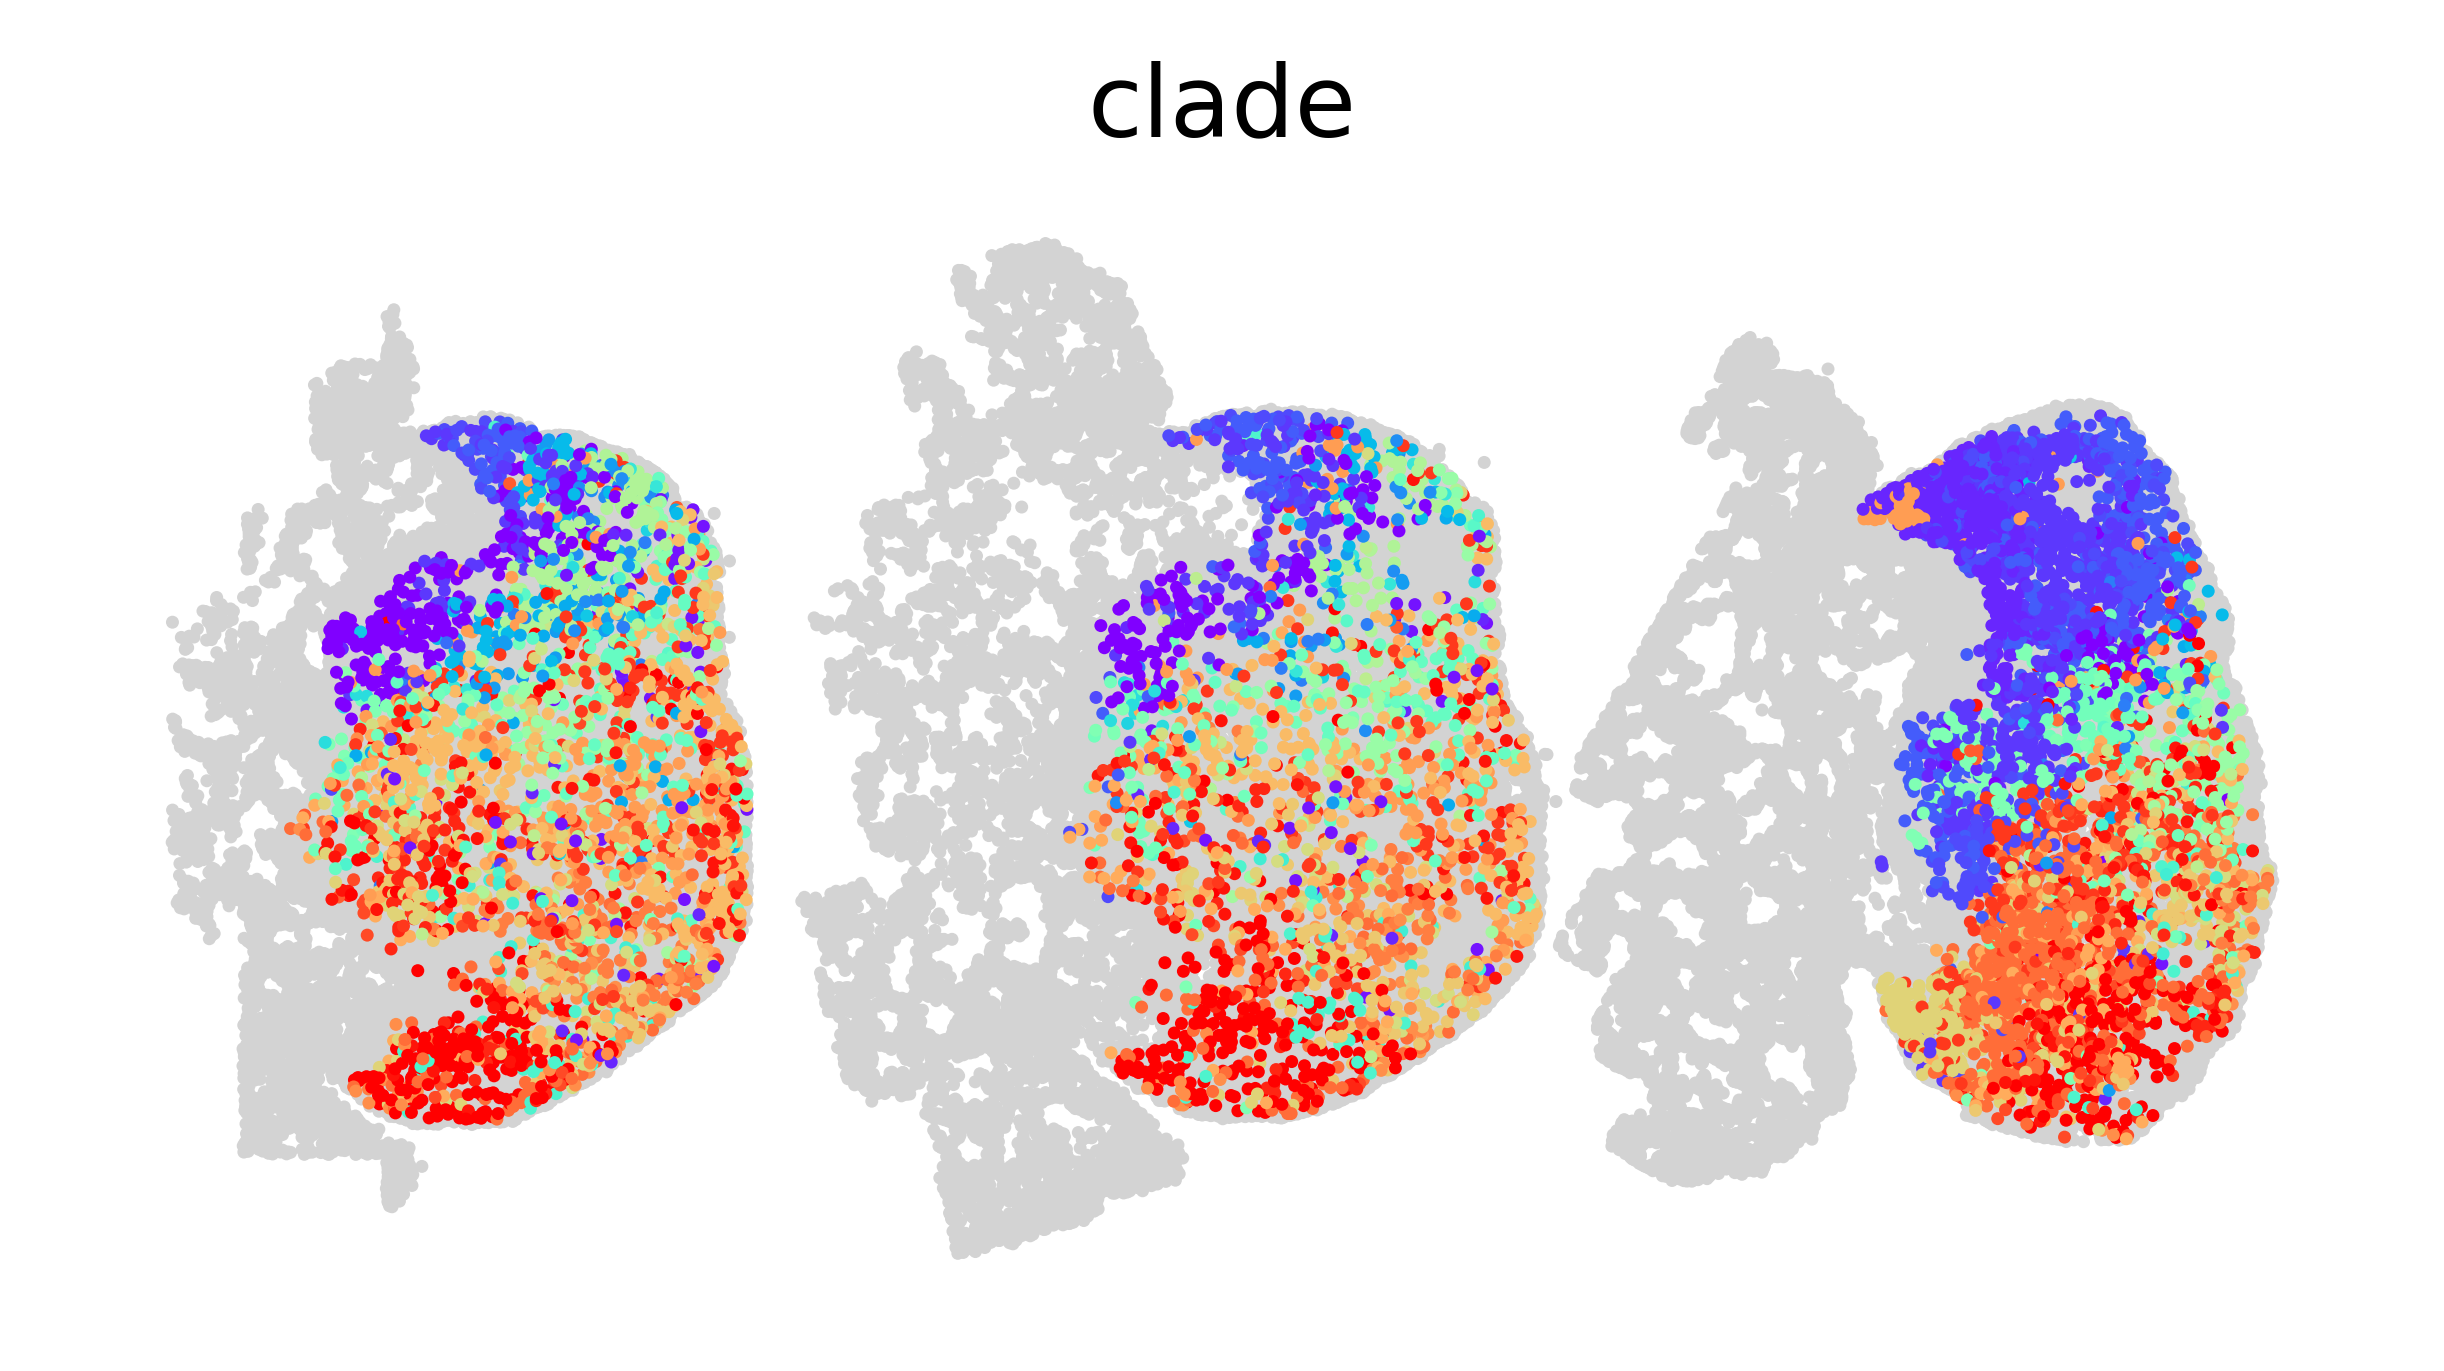

In [26]:
sc.pl.spatial(tdata, color="clade", spot_size=40, frameon=False, legend_loc=None);

## Number of extant cells

Now, let's use {func}`pycea.tl.n_extant` examine how the number of extant cells in each clade changes over time. This function counts the number of branches that are alive at time discrete points specified by `bins` with the option to group branches by a categorical variable(s) specified by `groupby`.

In [19]:
n_extant = py.tl.n_extant(tdata, depth_key="time", groupby="clade", bins = 20, dropna=True, copy=True)
n_extant.sort_values(["clade","time"]).head(10)

time  n_extant  tree clade
903   0.00         0  tree     0
904   1.75         0  tree     0
905   3.50         1  tree     0
906   5.25         1  tree     0
907   7.00         3  tree     0
908   8.75         4  tree     0
909  10.50         4  tree     0
910  12.25         7  tree     0
911  14.00        16  tree     0
912  15.75        23  tree     0

The number of extant cells can be visualized using {func}`pycea.pl.n_extant` with the `stat` specifying the statistic to use, one of `count`, `fraction`, or `percent`.

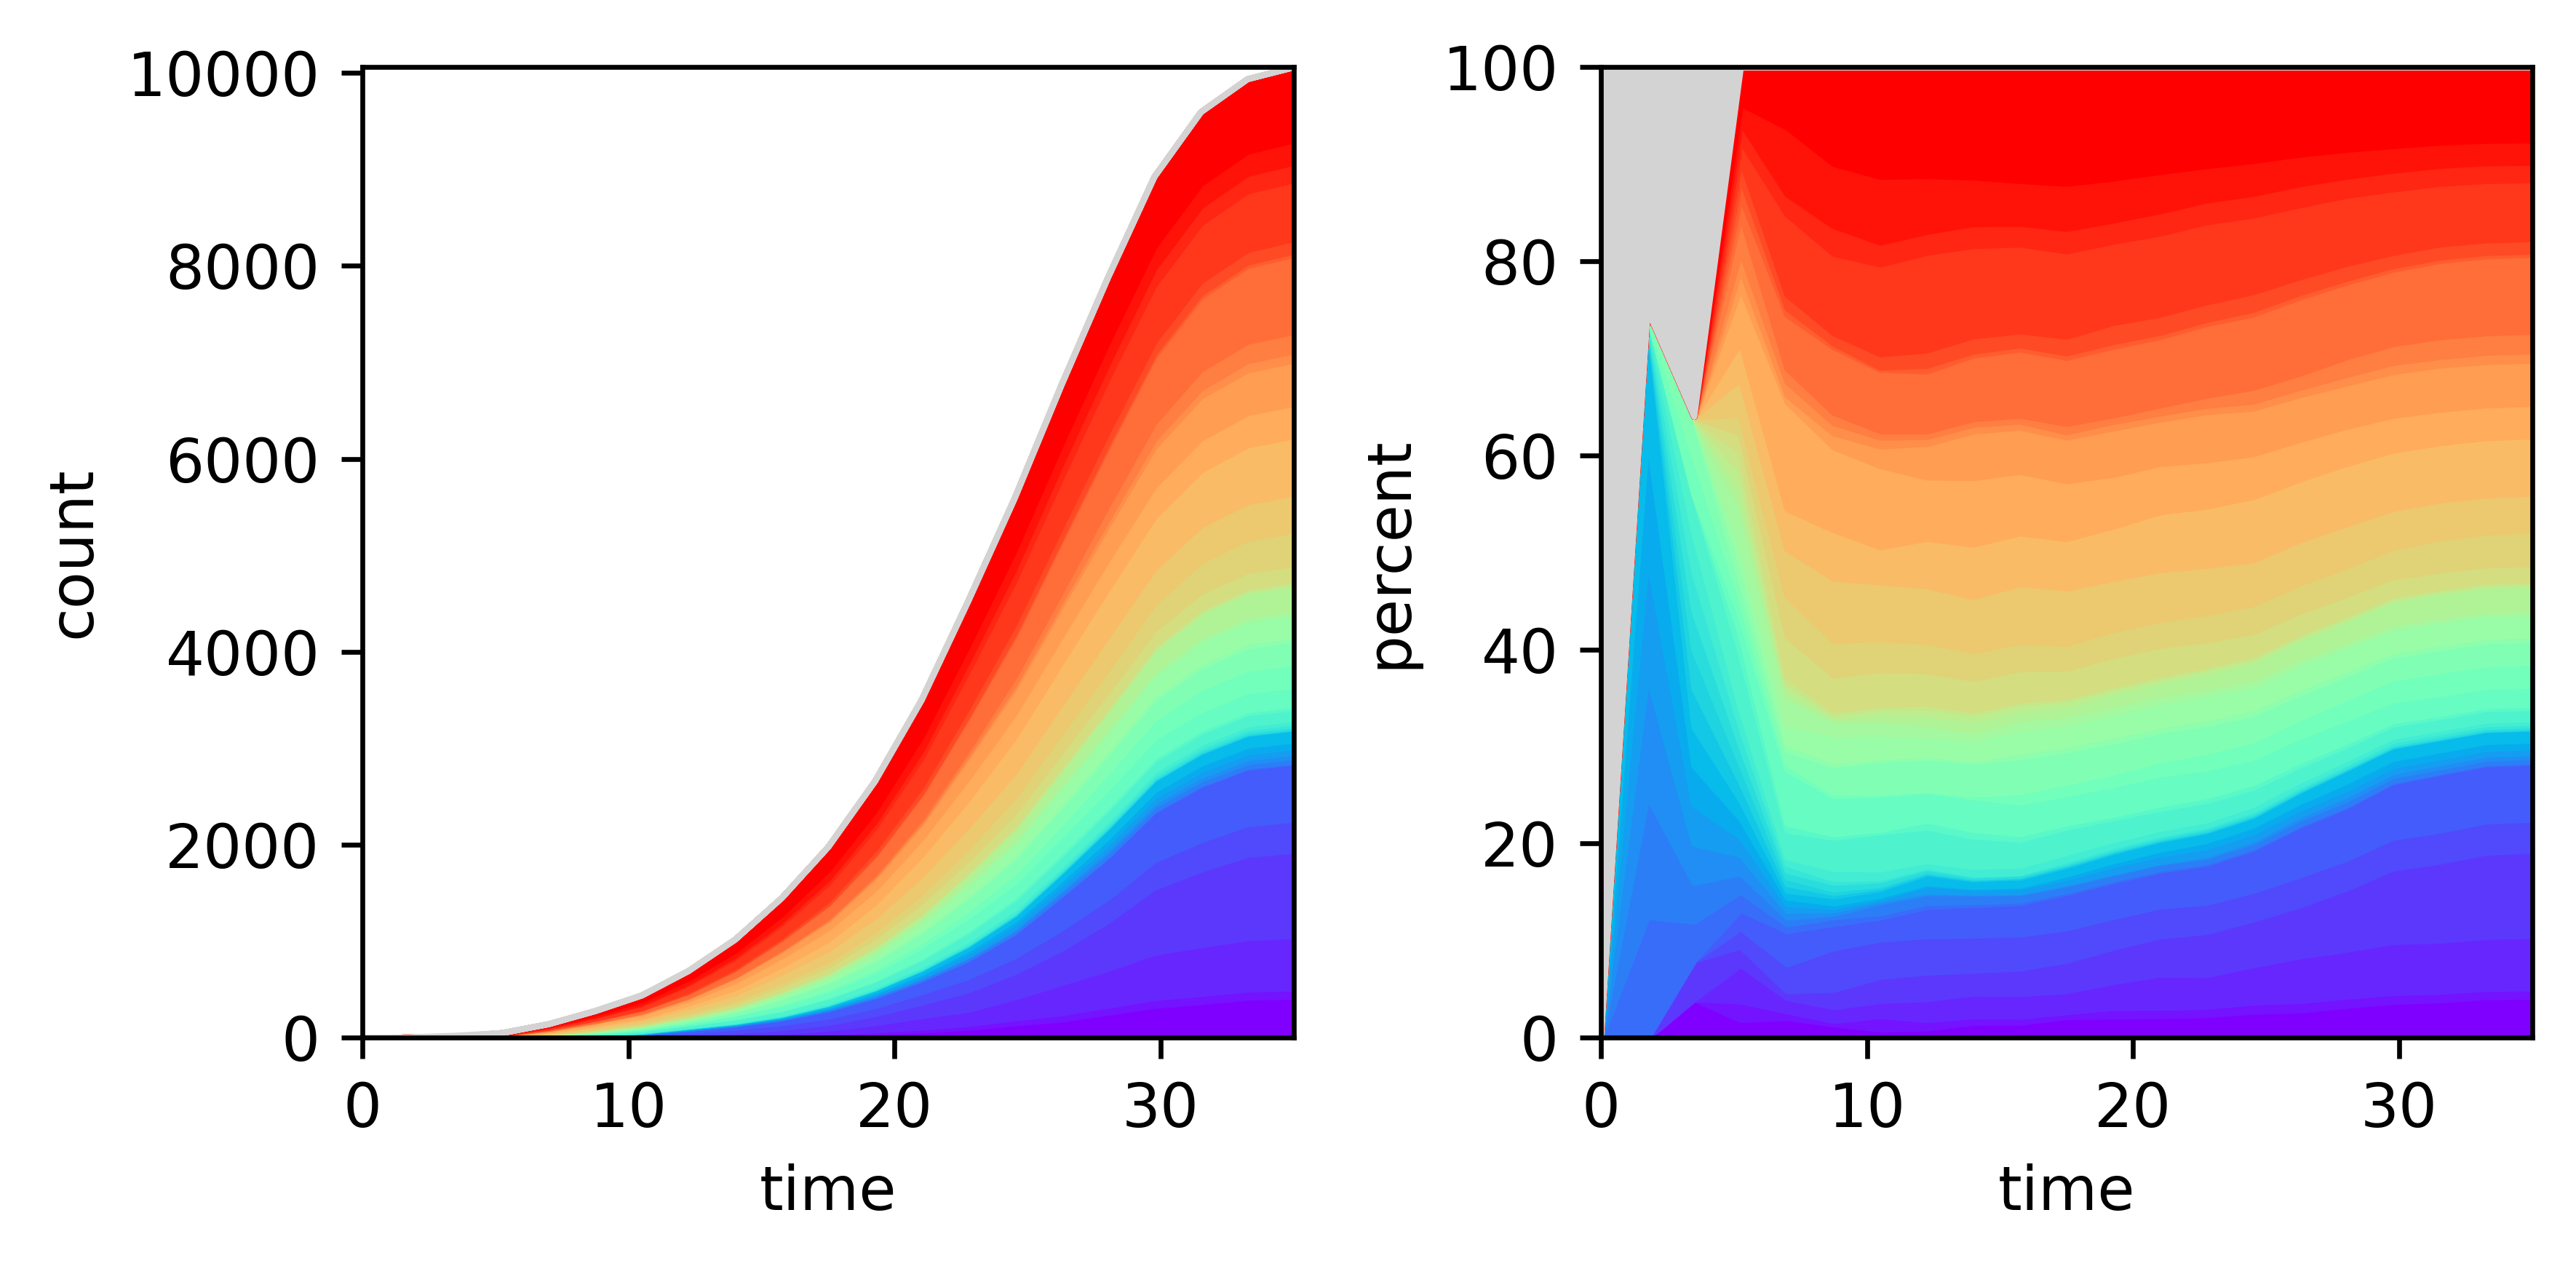

In [23]:
fig, axes = plt.subplots(1,2, figsize=(6,3))
py.pl.n_extant(tdata,ax = axes[0])
py.pl.n_extant(tdata,ax = axes[1], stat = "percent")
plt.tight_layout()

This plot reveals that the blue and purple clades expand more rapidly than the other clade after day 15.

## Fitness

Another way to look at growth are phylogenetic fitness metrics based on tree topology. The {func}`pycea.tl.fitness` function can be used to compute the Selection-Biased Diffusion (SBD) and Local Branching Index (LBI) metrics proposed by [Neher et al. 2014](https://elifesciences.org/articles/03568). We'll use SBD here since it is more accurate and can be computed in a reasonable for this dataset.

In [ ]:
py.tl.fitness(tdata, depth_key="time", method="sbd")

Now let't plot the tree annotating the leaves with the fitness estimates. As expected, the clades that expand more rapidly have higher fitness values.

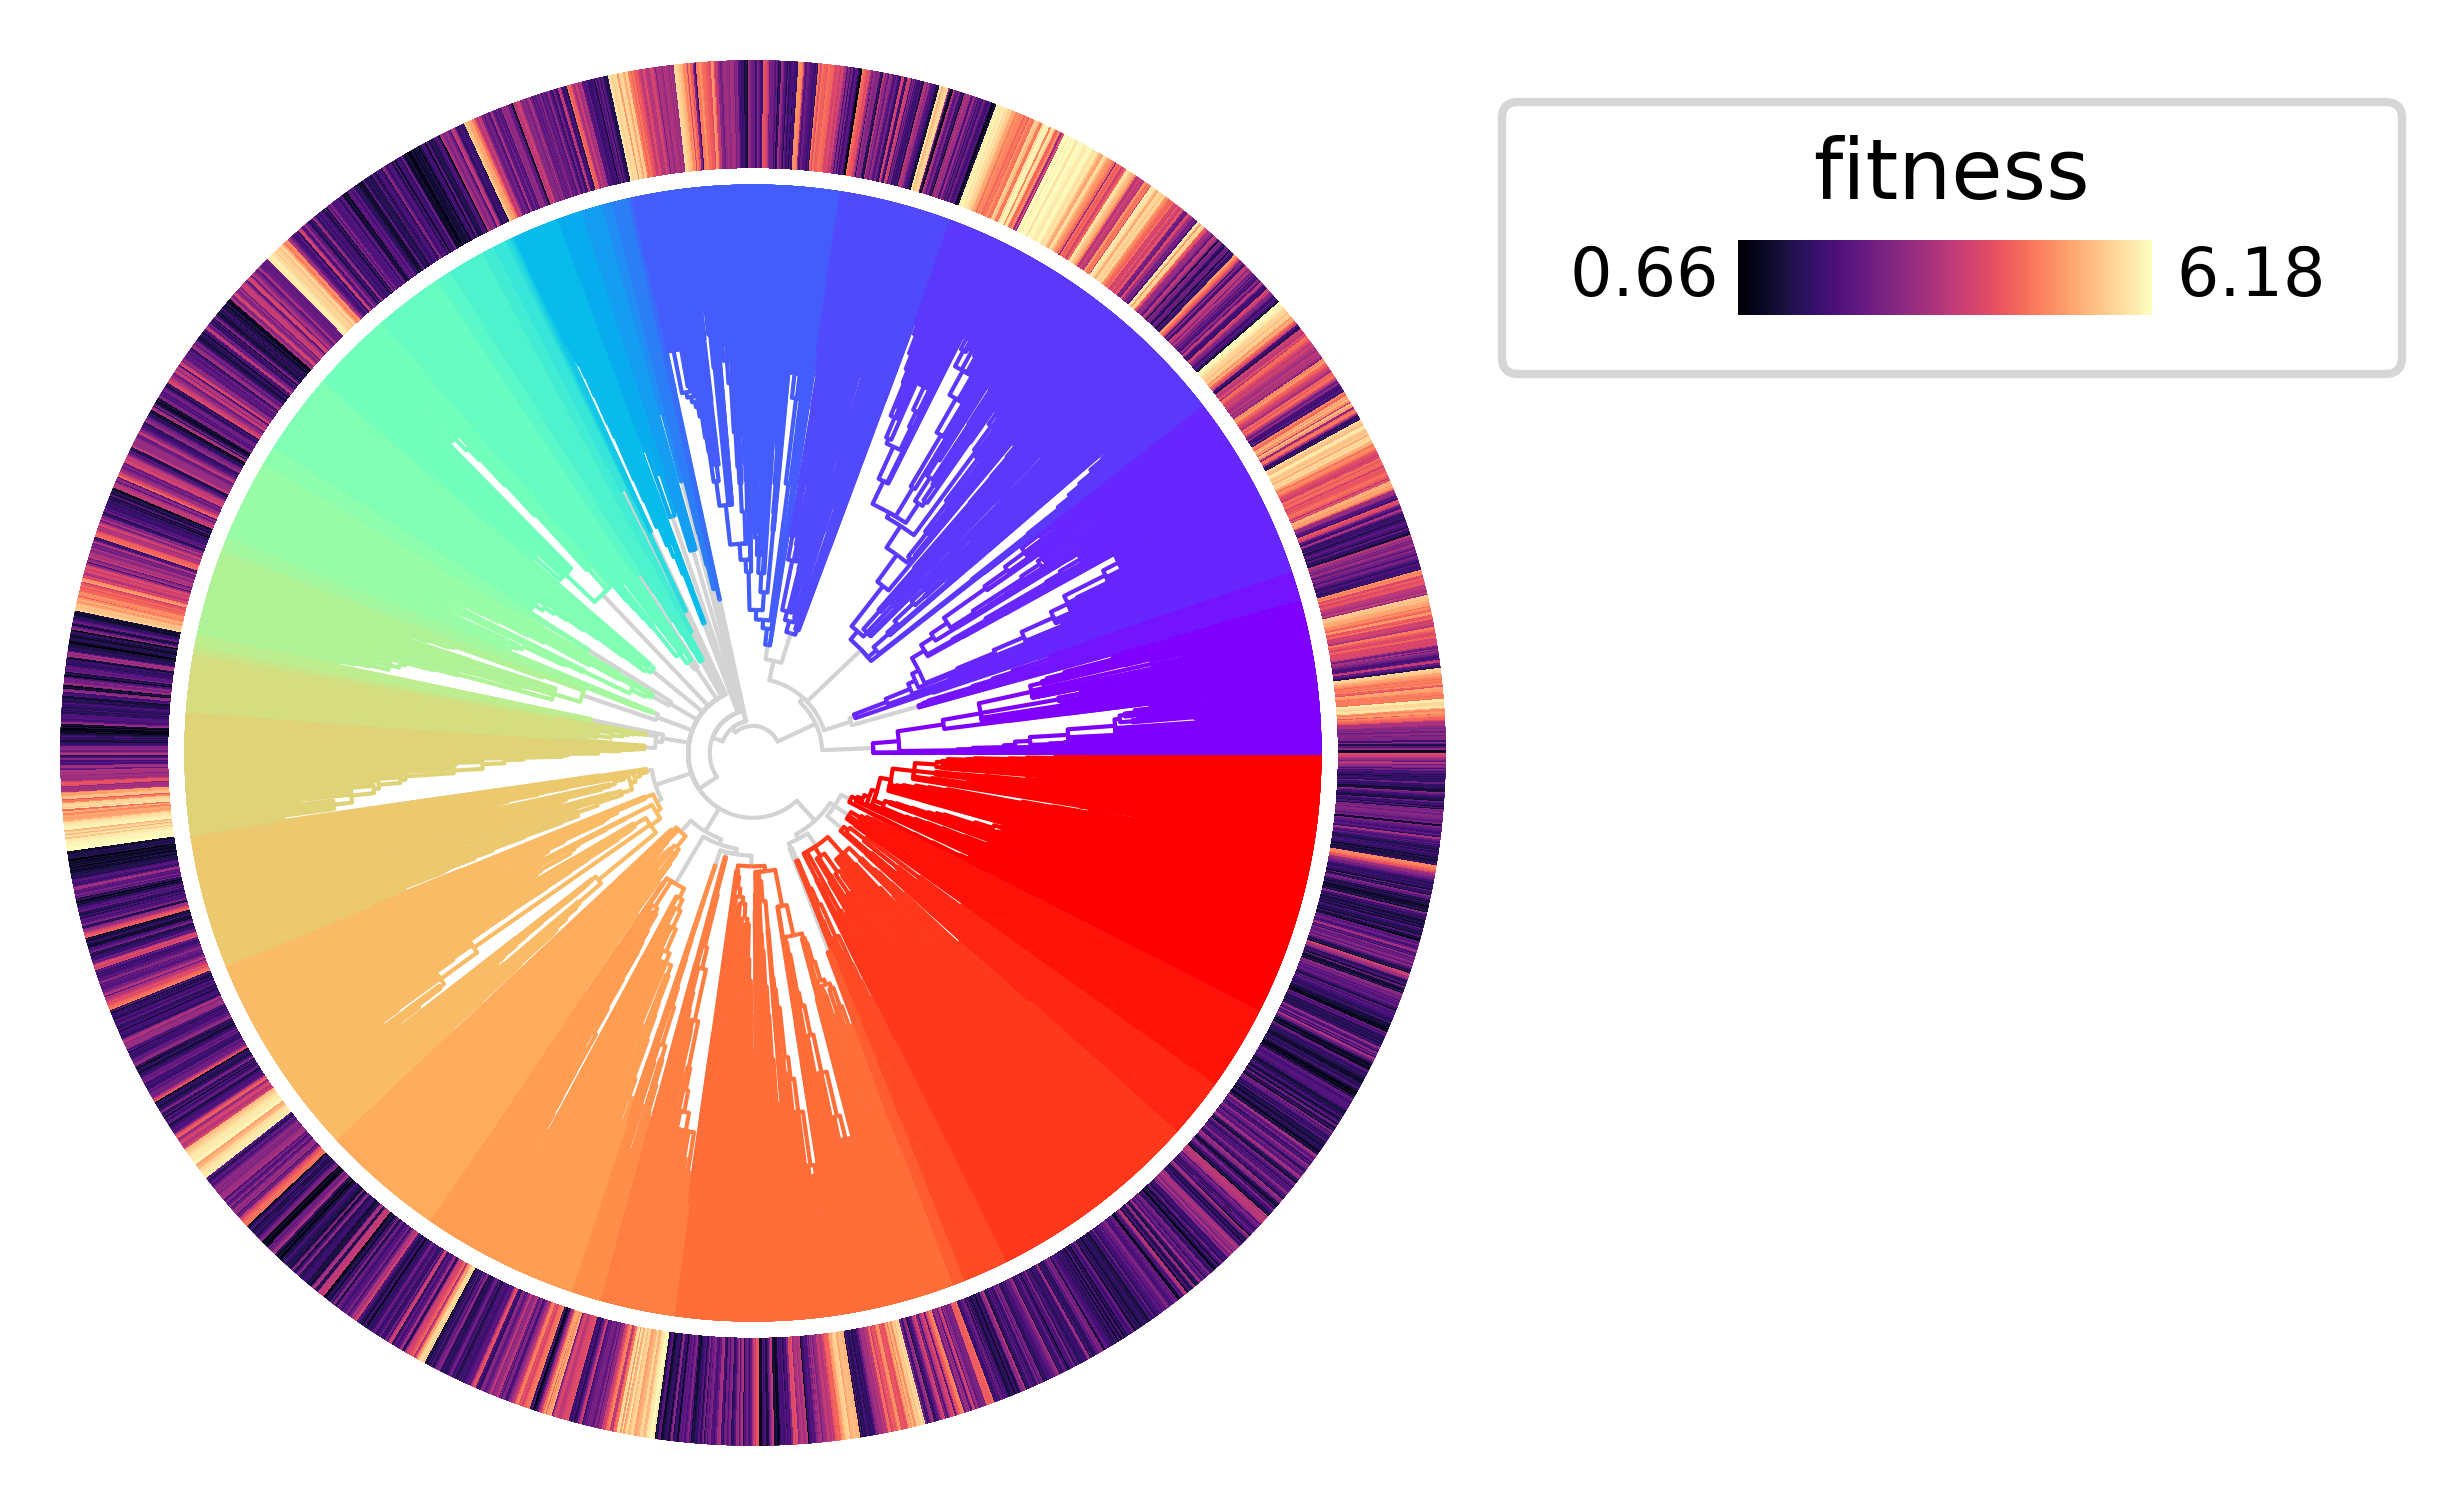

In [27]:
py.pl.tree(tdata,depth_key="time", branch_color="clade", palette=clade_palette, polar = True)
py.pl.annotation(tdata, keys = "fitness", width = .2, cmap = "magma");

We can also visualize the spatial distribution of fitness values in each tumor section.

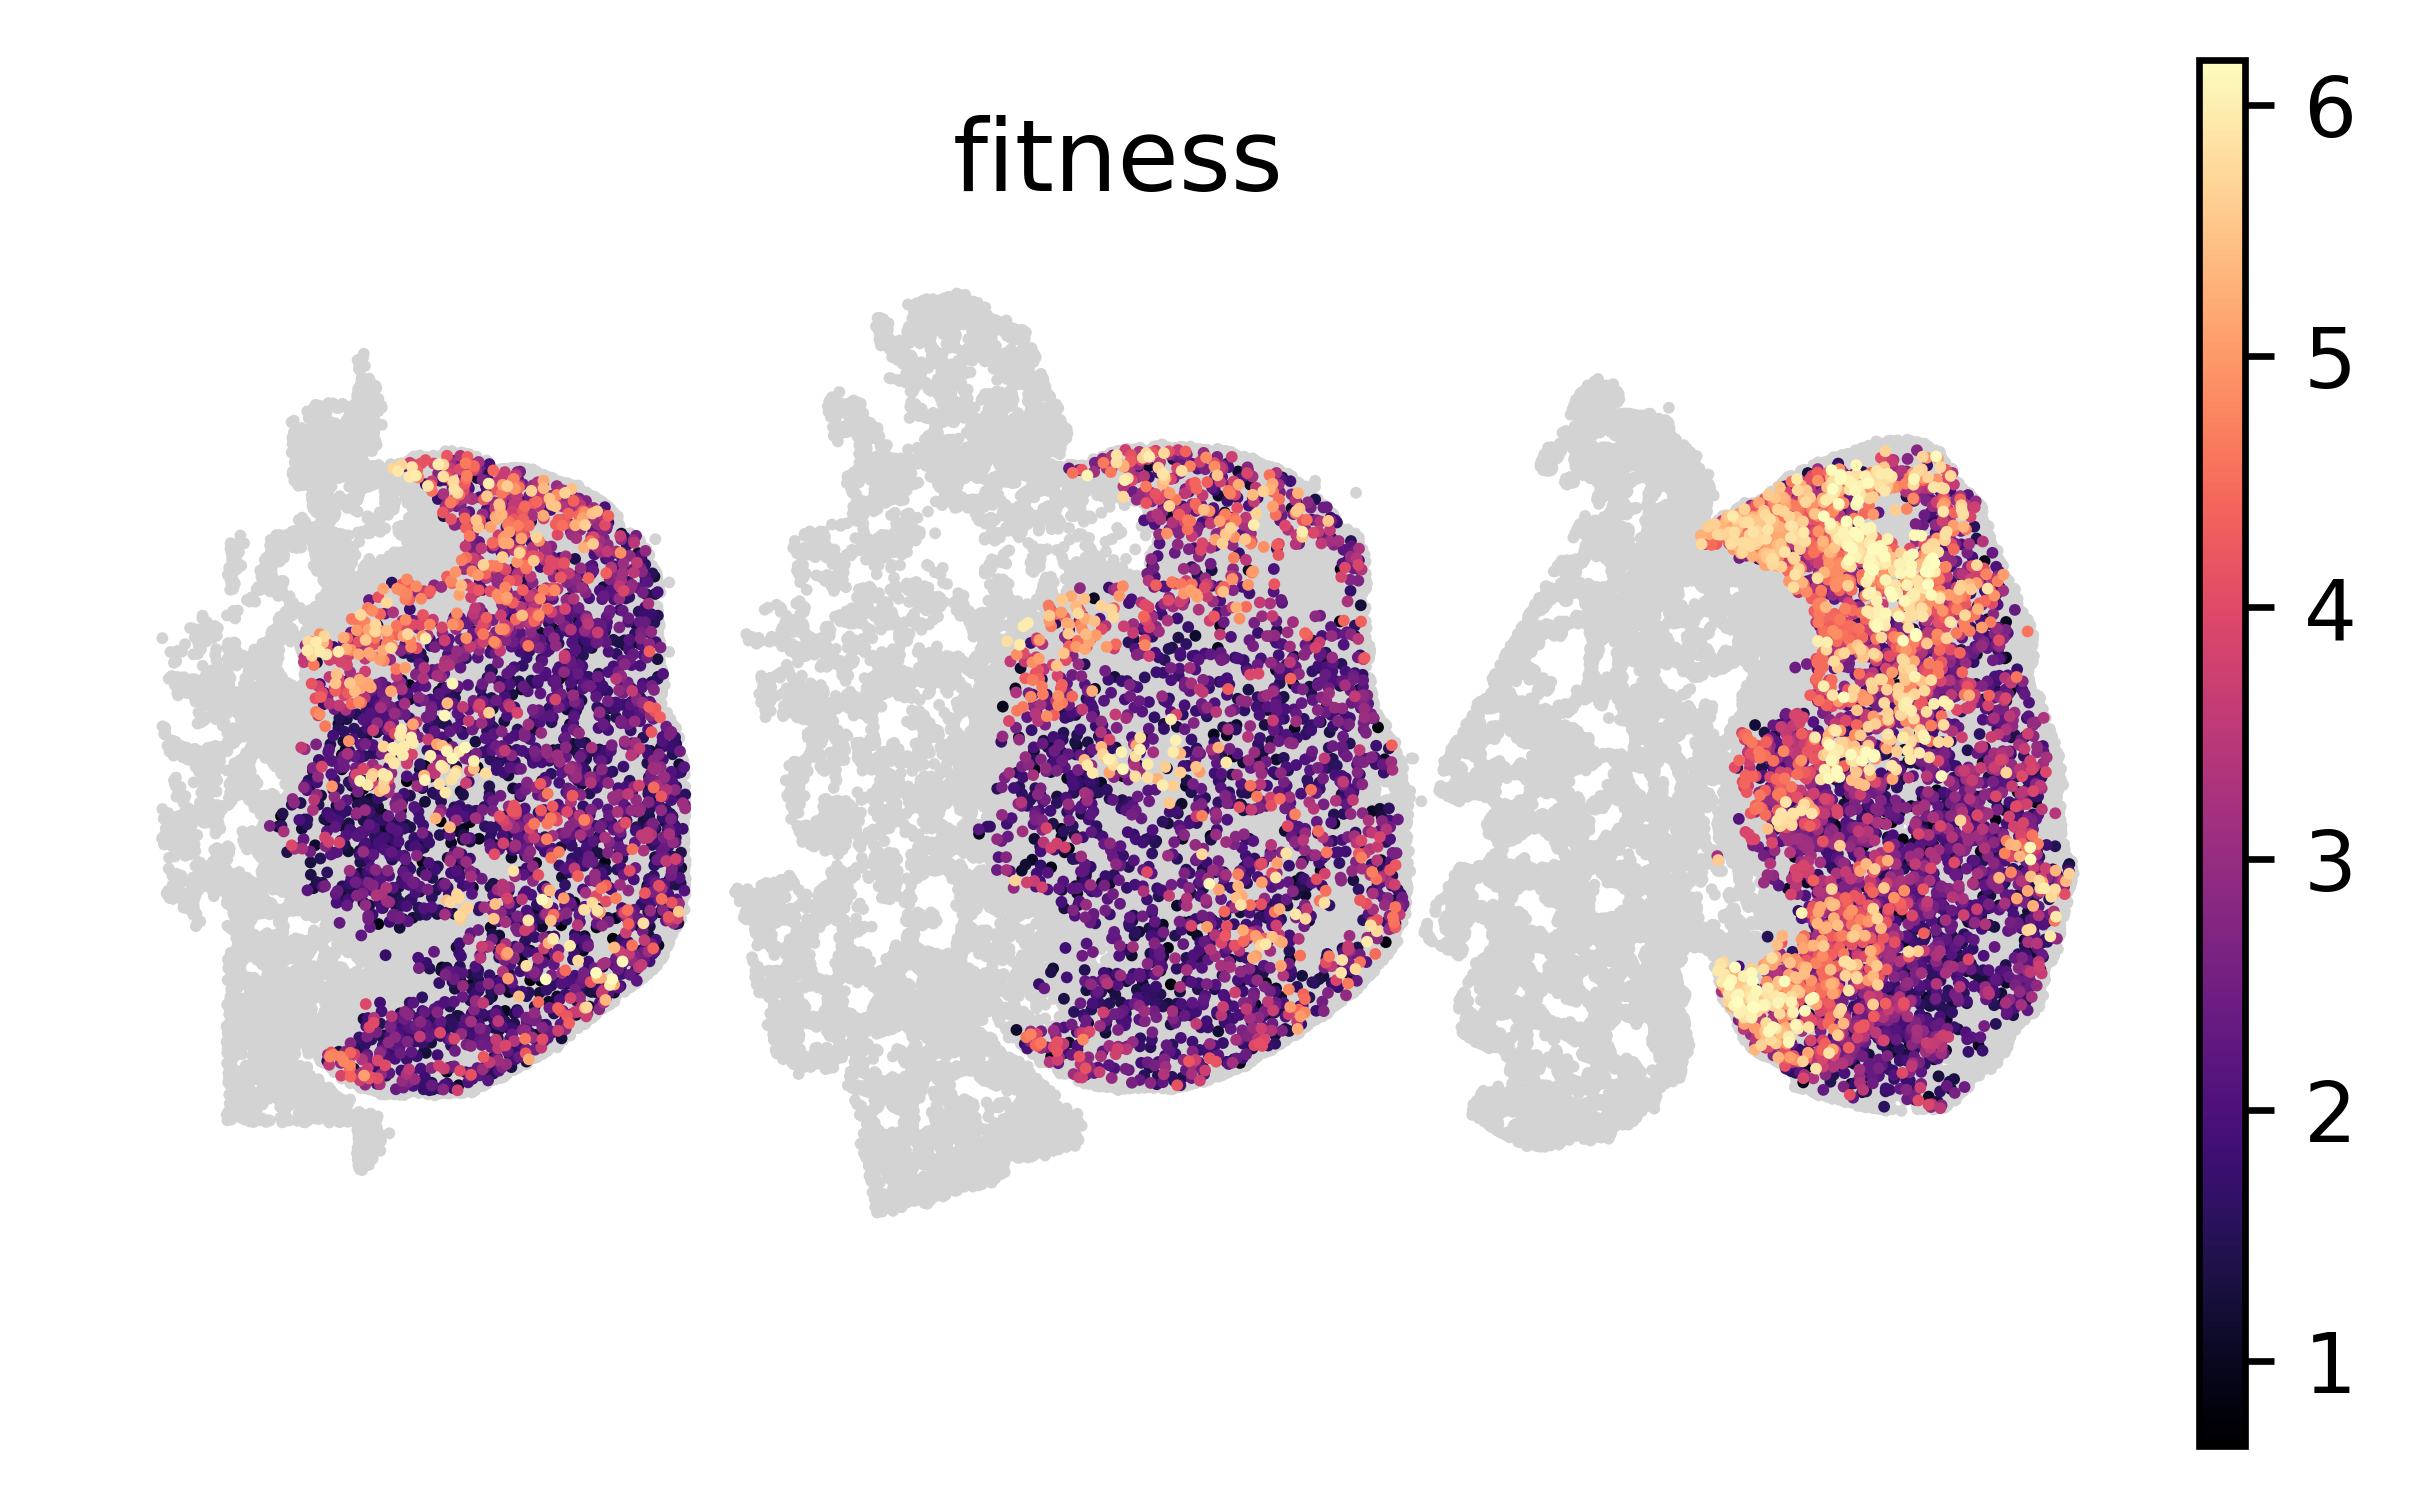

In [28]:
sc.pl.spatial(tdata, color="fitness", spot_size=40, frameon=False, cmap = "magma");

## Fitness drivers

Finally, to identify genes associated with fitness, we can compute the correlation between gene expression and fitness values.

In [14]:
expr = sc.get.obs_df(tdata,keys = list(tdata.var_names))
expr.corrwith(tdata.obs["fitness"]).sort_values(ascending=False).head(10)

Cldn4     0.155181
Lef1      0.115285
Fgfbp1    0.104625
Fgf1      0.098404
Ung       0.096257
Tcf7      0.074792
Gpr141    0.059153
Itgb6     0.059025
Cd300e    0.058426
Tubb1     0.057124
dtype: float64

The highest fitness clades also tend to have the highest expression of Cldn4

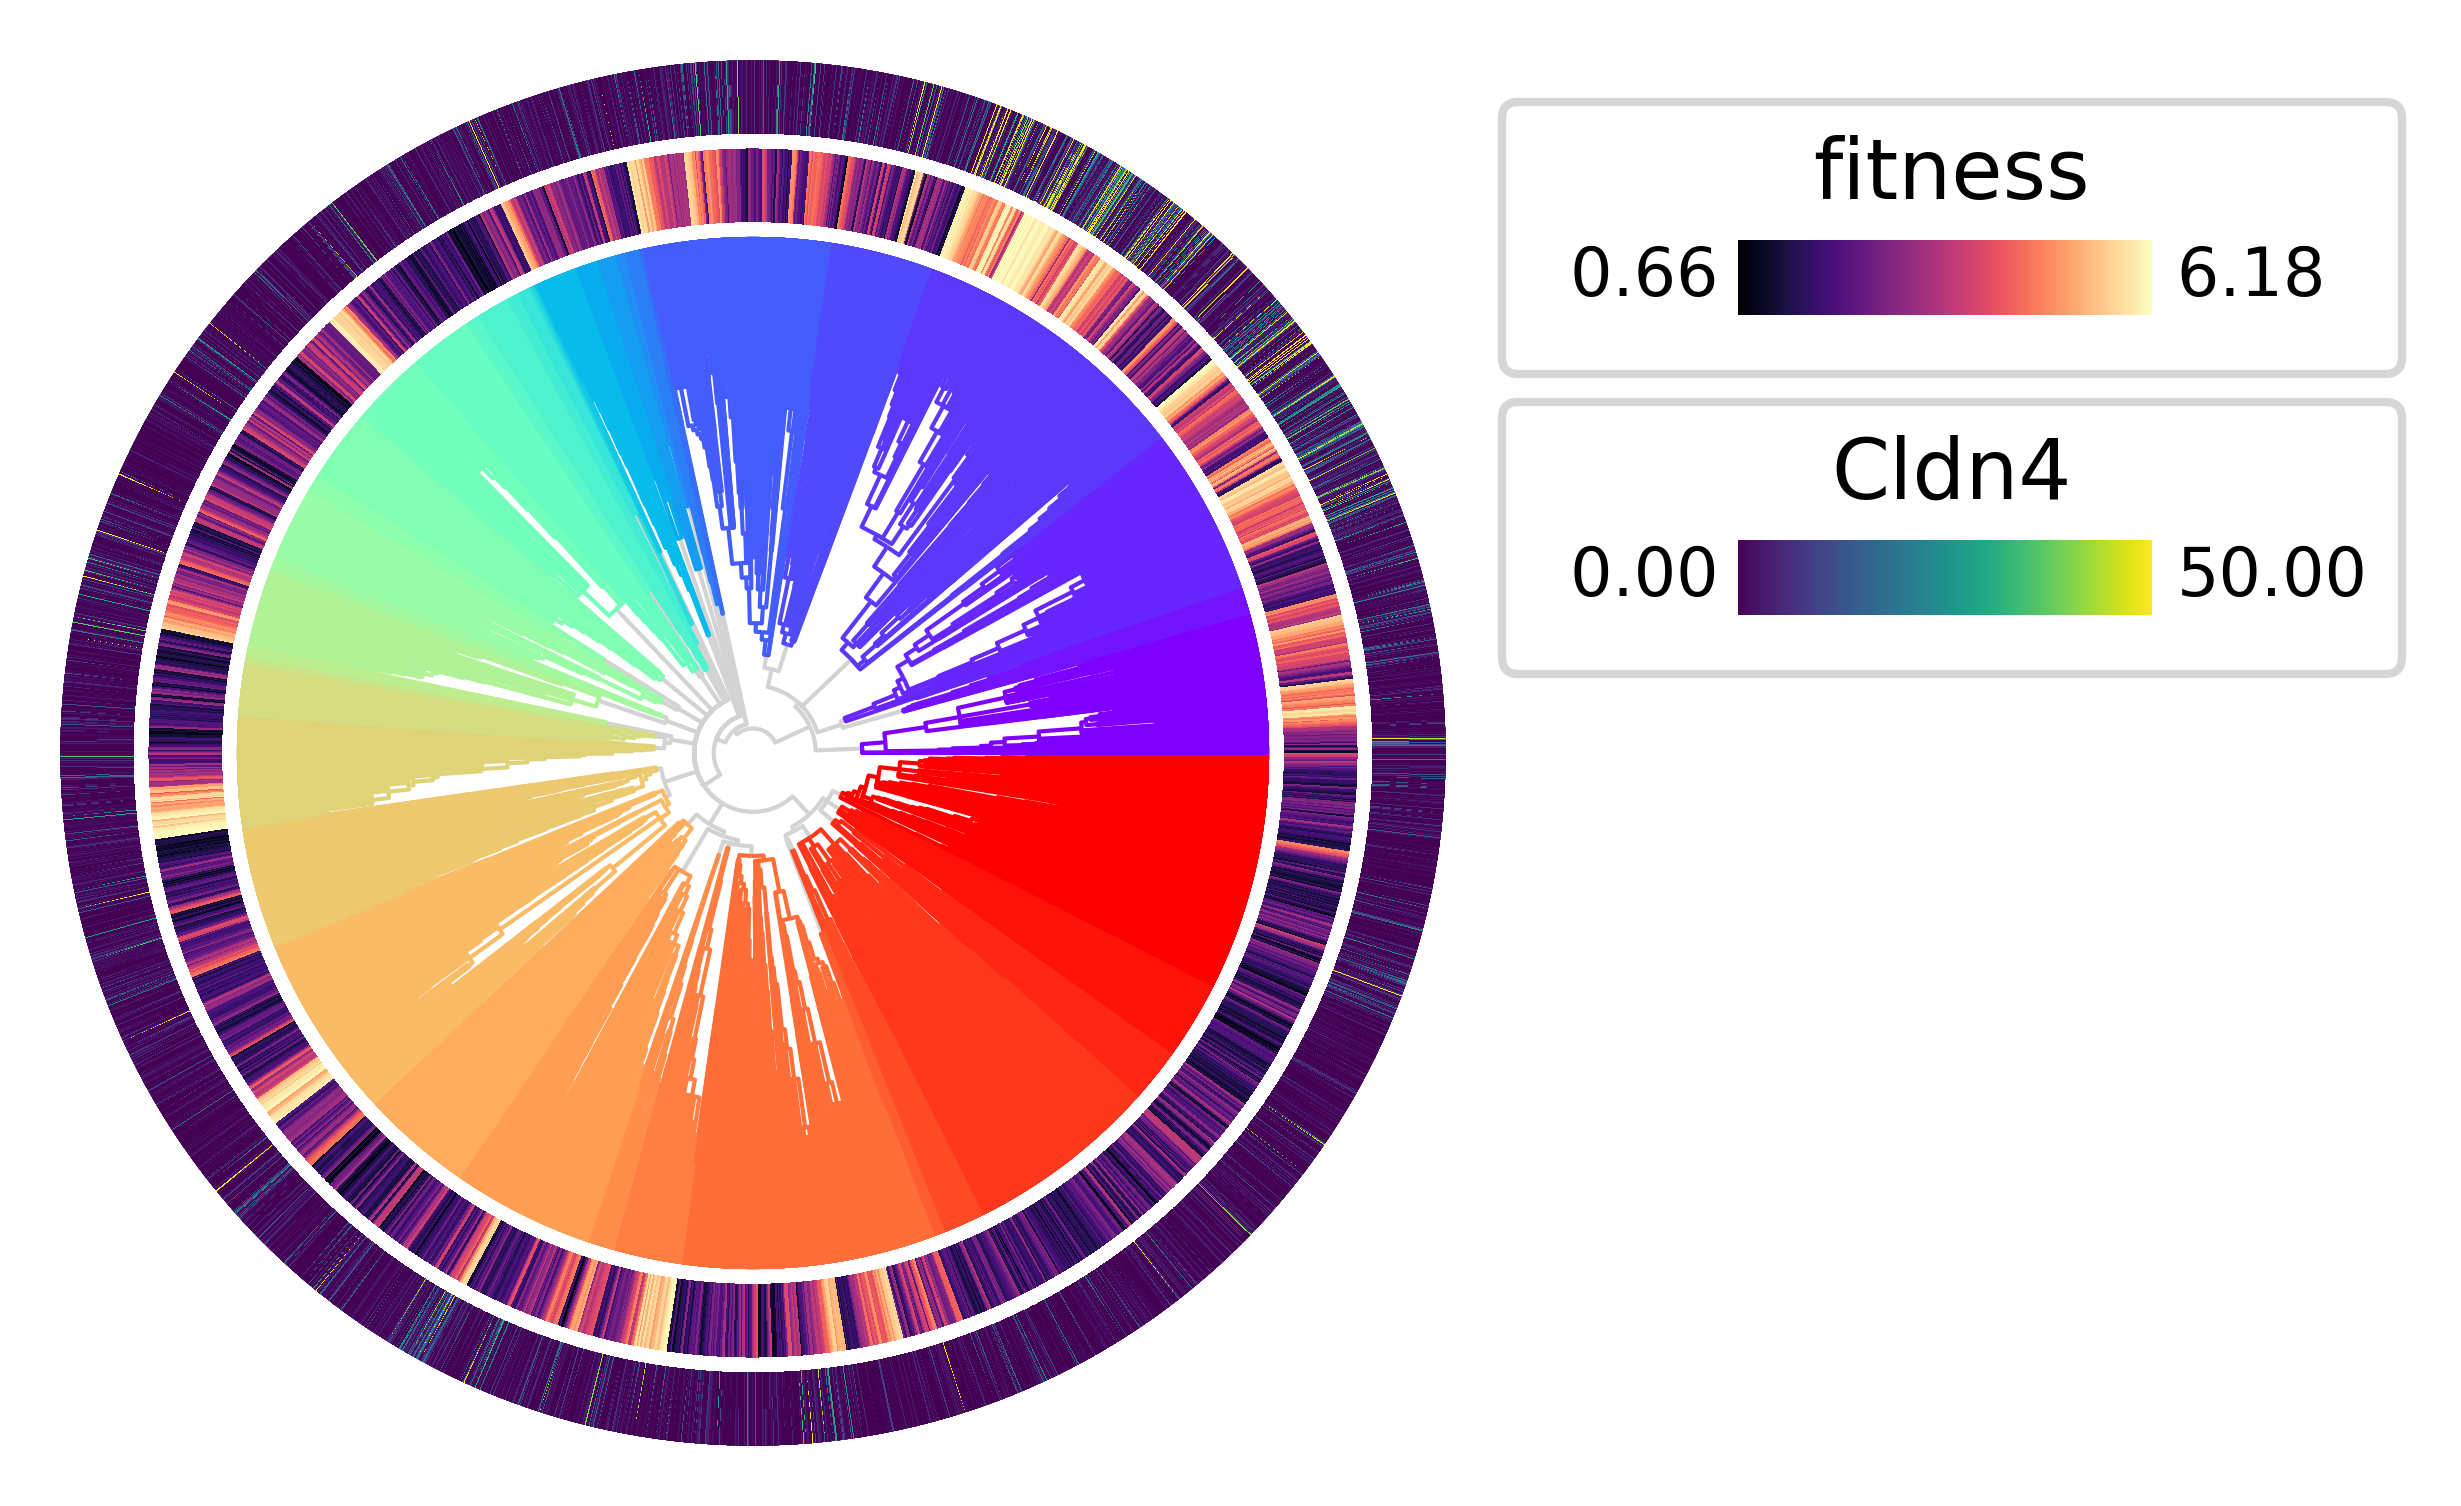

In [29]:
py.pl.tree(tdata,depth_key="time", branch_color="clade", palette=clade_palette, polar = True)
py.pl.annotation(tdata, keys = "fitness", width = .15, cmap = "magma")
py.pl.annotation(tdata, keys = "Cldn4", width = .15, vmax = 50);